# Haar interferometer and multimode squeezed vacuum

We test the boson sampling operator (no training) 
on squeezed states, and 
propagating in a Haar random medium

nonlinearxwaves@gmail.com<br>
@created 30 gennaio 2021<br>
@version 1 October 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import itertools as it

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=2)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Dimension

In [7]:
N = 12

In [8]:
n=np.floor_divide(N,2)

In [9]:
nmodes = int(n)

In [10]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [11]:
vacuum = ps.VacuumLayer(N)

## Parameter for squeezing

In [12]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [13]:
HAAR=ps.HaarLayerConstant(N)

## Build the model

In [14]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j)(x1,a1)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 single_mode_squeezer_layer (Si  [(None, 12),        2           ['haar_layer_constant[0][0]',    
 ngleModeSqueezerLayer)          (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                              

In [16]:
tf.keras.utils.plot_model(
    model, to_file='modelHaar.pdf', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

# Evaluate the covariance

In [17]:
%%time
cov_layer = ps.covariance(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 12), dtype=float32)
[[3.52306151 2.34875274 -0.546529591 ... 0.213970467 0.475807935 0.0709974468]
 [2.34875298 2.4614203 0.780656278 ... 0.469459504 0.0709975064 -0.475807965]
 [-0.546529591 0.780656099 3.64200783 ... -0.681139052 -0.52045691 -0.173872426]
 ...
 [0.213970408 0.469459563 -0.681139052 ... 4.69536638 -0.830417871 0.240936011]
 [0.475807935 0.0709975287 -0.520456851 ... -0.830417812 0.605559766 0.53688556]
 [0.0709975213 -0.475808 -0.173872441 ... 0.240936115 0.536885679 5.37892246]]
CPU times: user 1.99 s, sys: 45.1 ms, total: 2.03 s
Wall time: 2.09 s


# Evaluate the Qtransform with calculated covariance and displacement

In [18]:
Qrho = ps.QTransform(cov0, d0)

# Test the Pr operator 

Probability of zero photon

In [19]:
%%time
ps.Pr([0]*nmodes, Qrho)

CPU times: user 10.9 ms, sys: 3.74 ms, total: 14.6 ms
Wall time: 14.7 ms


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.13]], dtype=float32)>

# Generate all the possible photon patterns assuming one photon per mode

In [20]:
def patterns(nphotons, nmodes):
    l1=[0]*nmodes
    for j in range(nphotons):
        l1[j]=1
    nlist=it.permutations(l1,nmodes)
    ln=list(nlist)
    ln.sort()
    # remove duplicates
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [21]:
%%time
ln =patterns(2,nmodes)
# number of generated patterns
print(len(ln))

15
CPU times: user 567 µs, sys: 132 µs, total: 699 µs
Wall time: 674 µs


## Make a plot versus the probability

Build an array of photon number sampling

In [22]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    print('--------------------')
    xaxis[nbar]=nbar #store for plot 
print('Done')

Sample 0 of 15 (0, 0, 0, 0, 1, 1)
Computed by the neural network: 0.0058979467
--------------------
Sample 1 of 15 (0, 0, 0, 1, 0, 1)
Computed by the neural network: 0.0008230279
--------------------
Sample 2 of 15 (0, 0, 0, 1, 1, 0)
Computed by the neural network: 0.0016531926
--------------------
Sample 3 of 15 (0, 0, 1, 0, 0, 1)
Computed by the neural network: 0.0046109343
--------------------
Sample 4 of 15 (0, 0, 1, 0, 1, 0)
Computed by the neural network: 0.023890592
--------------------
Sample 5 of 15 (0, 0, 1, 1, 0, 0)
Computed by the neural network: 0.0026169836
--------------------
Sample 6 of 15 (0, 1, 0, 0, 0, 1)
Computed by the neural network: 0.0023753466
--------------------
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
Computed by the neural network: 0.0057893256
--------------------
Sample 8 of 15 (0, 1, 0, 1, 0, 0)
Computed by the neural network: 0.016228877
--------------------
Sample 9 of 15 (0, 1, 1, 0, 0, 0)
Computed by the neural network: 0.0148854945
--------------------
Sa

/home/claudio/.local/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


CPU times: user 394 ms, sys: 180 ms, total: 573 ms
Wall time: 230 ms


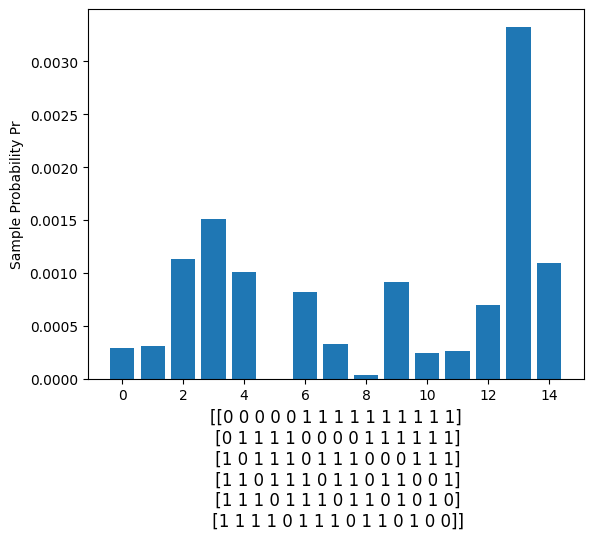

In [30]:
%%time
plt.bar(xaxis,Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr');
plt.savefig('BosonSamplingExample6.pdf', format='pdf', bbox_inches='tight')

Probability of the photon patterns
Sampling patters are indicate in the labels.

In [24]:
print(Pn)

[0.01 0.   0.   0.   0.02 0.   0.   0.01 0.02 0.01 0.   0.   0.   0.
 0.01]


In [25]:
np.sum(Pn)

0.09577264

# Compute the statistical probability of pairs

In [26]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.1257302314043045 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.005897946655750275 pattern (0, 0, 0, 0, 1, 1)
Photons 2 Sample 2 of 15 Pr=0.0008230279199779034 pattern (0, 0, 0, 1, 0, 1)
Photons 2 Sample 3 of 15 Pr=0.0016531925648450851 pattern (0, 0, 0, 1, 1, 0)
Photons 2 Sample 4 of 15 Pr=0.004610934294760227 pattern (0, 0, 1, 0, 0, 1)
Photons 2 Sample 5 of 15 Pr=0.02389059215784073 pattern (0, 0, 1, 0, 1, 0)
Photons 2 Sample 6 of 15 Pr=0.0026169836055487394 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.0023753466084599495 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 8 of 15 Pr=0.005789325572550297 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.016228877007961273 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 10 of 15 Pr=0.014885494485497475 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.0018257149495184422 pattern (1, 0, 0, 0, 0, 1)

In [27]:
probn

array([0.13, 0.1 , 0.01])

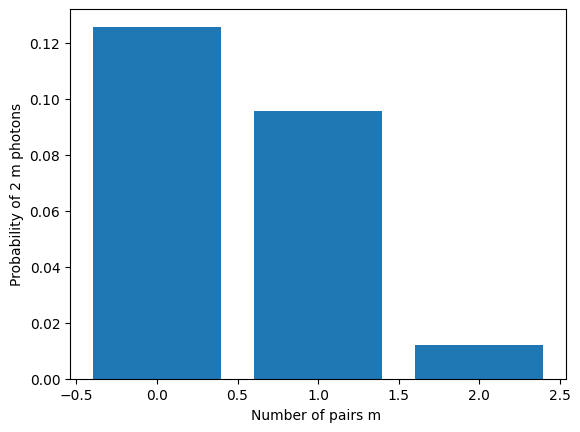

In [28]:
plt.bar(range(nmax+1),probn)
plt.ylabel('Probability of 2 m photons');
plt.xlabel('Number of pairs m ');
plt.savefig('BosonSamplingExample6ALL.pdf', format='pdf')   